# Tesis

Este es el cuaderno de Jupyter para la implementación de la tesis. <br >
Este código utiliza el trabajo realizado por Diego Gomez (Poner aquí link al artículo de el, o el github o lo que sea) y lo aplica al problema de la regulación del nivel de glucosa en la sangre en pacientes Diabéticos Tipo 1. <br >
Se utiliza la librería de "simglucose" que permite simular la dinámica de la glucosa, de acuerdo con el simulador aprobado por la FDA de UVa/Padova (Versión 2008). <br >
Link de la librería de simglucose: https://github.com/jxx123/simglucose <br >
Link del GitHub de Diego: https://github.com/tarod13 <br >

# Tareas
1. Entender bien la librería de simglucose: rewards, acciones, estados, todo eso. (En progreso: ~5%) 
2. Hacer lo del mapeo de estados a acciones: s->a (En progreso: ~80%)
3. Hacer lo del mapeo de estados a Habilidades: s->A (Sin comenzar: 0%)
4. Implementar lo de Diego para encontrar los conceptos: s->S (Sin comenzar: 0%)
5. Analizar todo

In [1]:
import time, copy, random
import numpy as np
import pandas as pd
from collections import deque

import progressbar
import gym
import simglucose

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.initializers import RandomNormal
from keras.models import load_model

%matplotlib inline
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Using TensorFlow backend.


In [2]:
class ExperienceReplay():
    def __init__(self, tamano_minimo = 1000, tamano_maximo = 10**5, tamano_batch = 32, column_names = ['St', 'At', 'St+1', 'Rt+1', 'done']):
        self.tamano_buffer = 0
        self.indice = 0
        self.tamano_batch = tamano_batch
        self.tamano_minimo = tamano_minimo
        self.tamano_maximo = tamano_maximo
        self.columnas = column_names
        
        self.buffer = self.inicializarBuffer()
        self.buffer.columns = column_names
        #self.indices = range(self.tamano_maximo)
    
    def inicializarBuffer(self):
        aux = pd.DataFrame(np.zeros((10**4,5)), dtype = 'object')
        #aux = pd.DataFrame({'St': None, 'At': [np.array([0,0])],
        #                   'Rt+1': [np.array([0,0])], 'St+1': [np.array([0,0])],
        #                   'done': [np.array([0,0])]})
        
        buffer = []
        
        for i in range(int(self.tamano_maximo/10**4)):
            buffer.append(aux)
        
        return pd.concat(buffer)
    
    def agregarDato(self, x, a, r, xp, d):
        
        if(self.indice == self.tamano_maximo):
            self.indice = 0
            
        self.buffer.iloc[self.indice]['St'] = x
        self.buffer.iloc[self.indice]['At'] = a
        self.buffer.iloc[self.indice]['Rt+1'] = r
        self.buffer.iloc[self.indice]['St+1'] = xp
        self.buffer.iloc[self.indice]['done'] = d

        self.indice +=1
        
        if self.tamano_buffer < self.tamano_maximo:
            self.tamano_buffer += 1
    
    def darMuestras(self):
        #indices = random.sample(self.indices[0:self.tamano_buffer], self.tamano_batch)
        indices = random.sample(range(self.tamano_buffer), self.tamano_batch)
        return self.buffer.iloc[indices]

In [3]:
# Codigo tomado de: https://github.com/jxx123/simglucose

# Basal: Largo plazo
# Bolus: Corto plazo

# Register gym environment. By specifying kwargs,
# you are able to choose which patient to simulate.
# patient_name must be 'adolescent#001' to 'adolescent#010',
# or 'adult#001' to 'adult#010', or 'child#001' to 'child#010'

#Cada vez que se crea un env se construye de manera aleatoria
#Por ejemplo, la cantidad de carbohidratos que se consumen y 
#el tiempo en el que se consumen es aleatoria.

from gym.envs.registration import register
register(
    id='simglucose-adolescent2-v0',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'adolescent#002'}
)

In [4]:
#Creando redes neuronales

def crearRedes(num_entrada, num_salida, n1 = 256, n2 = 256, learning_rate = 0.01):
    init = RandomNormal(seed = 0)
    
    modelo = Sequential()
    
    modelo.add(Dense(n1, activation = 'relu', kernel_initializer = init, bias_initializer = init, input_dim = num_entrada))
    modelo.add(Dense(n2, activation = 'relu', kernel_initializer = init, bias_initializer = init))
    #modelo.add(Dense(n2, activation = 'relu', kernel_initializer = init, bias_initializer = init))
    modelo.add(Dense(num_salida, activation = 'linear', kernel_initializer = init, bias_initializer = init))
    
    sgd = optimizers.sgd(lr = learning_rate)
    
    modelo.compile(loss = 'mean_squared_error', optimizer = sgd, metrics = ['accuracy'])
    
    return modelo, copy.deepcopy(modelo)

def actualizarRedTarget(pRedPrincipal, pRedTarget):
    
    for i in range(len(pRedPrincipal.layers)):
        pesosPrincipal = pRedPrincipal.layers[i].get_weights()
        pesosTarget = pRedTarget.layers[i].get_weights()
        
        pesos = [tao*l1 + (1-tao)*l2 for l1, l2 in zip(pesosPrincipal, pesosTarget)]
        
        pRedTarget.layers[i].set_weights(pesos)

def escogerAccion(pModelo, pX, pNumAcciones):
    num = np.random.random()
    
    if(num <= epsilon):
        ind = np.random.randint(0, pNumAcciones)
        return ind
    else:
        #Esto creo que es como lento. Hacerlo mejor.
        #Usando deque:
        x = np.reshape(np.asarray(pX), (1,-1))
        ind = np.argmax(pModelo.predict(x))
        return ind
    
def convertirAccion(pAccion, pMaxAccion, pNumAcciones):
    return pAccion*pMaxAccion/float(pNumAcciones)

In [7]:
0.9998**10000

0.13530821527775996

In [7]:
%timeit env = gym.make(envName)

18.4 ms ± 623 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
test = np.array(state_queue)*max_norm
test2 = np.reshape(test, (1,-1))
print(test2)

[[0.0075     0.         0.06666667 0.0075     0.         0.06666667
  0.0075     0.         0.06666667 0.0075     0.         0.06666667
  0.0075     0.         0.06666667 0.0075     0.         0.06666667
  0.0075     0.         0.06666667 0.0075     0.         0.06666667
  0.0075     0.         0.06666667 0.0075     0.         0.06666667
  0.0075     0.         0.06666667 0.0075     0.         0.06666667
  0.0075     0.         0.06666667 0.0075     0.         0.06666667
  0.0075     0.         0.06666667 0.0075     0.         0.06666667
  0.0075     0.         0.06666667 0.0075     0.         0.06666667
  0.0075     0.         0.06666667 0.0075     0.         0.06666667
  0.0075     0.         0.06666667 0.0075     0.         0.06666667
  0.0075     0.         0.06666667 0.0075     0.         0.06666667
  0.0075     0.         0.06666667 0.0075     0.         0.06666667
  0.0075     0.         0.06666667 0.0075     0.         0.06666667
  0.0075     0.         0.06666667 0.0075     0.

In [24]:
test3 = deque(maxlen = num_estados)

for i in range(num_estados):
    test3.append([159.0, 0.0, 1.0])
    
print(test3)

deque([[159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0], [159.0, 0.0, 1.0]], maxlen=40)


In [45]:
0.9998**10000

0.13530821527775996

100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (10000 of 10000) |##################| Elapsed Time: 4:06:29 Time:  4:06:29


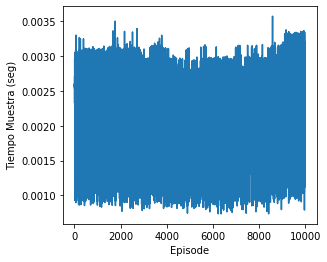

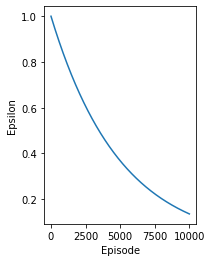

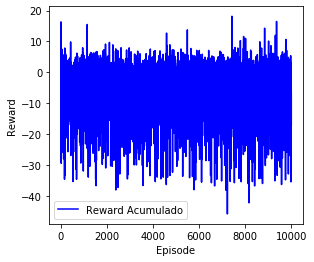

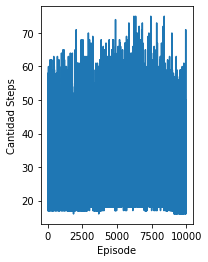

Total training time:  14792.29 seconds


In [46]:
np.random.seed(123)

envName = 'simglucose-adolescent2-v0'
env = gym.make(envName)

num_episodes = 10000
num_steps = 200
num_steps_train = 100
epsilon = 1.0
epsilon_decay = 0.9998
tao = 0.001
gamma = 0.99
batch_size = 32

total_steps_log = []
epsilon_log = []
muestras_log = []
rewards_acumulados = []
rewards_promedio = []
cantidad_steps_log = []

buffer = ExperienceReplay(tamano_minimo = 100)

#num_estados_glucosa = 20
#num_estados_insulina = 20
#num_estados_cho = 20
num_estados = 40#num_estados_glucosa + num_estados_insulina + num_estados_cho
max_estados = num_estados#max(num_estados_glucosa, num_estados_insulina, num_estados_cho)

num_acciones = 30
max_accion = 30.0
max_glucosa = 200.0
max_cho = 30
max_norm = [1/max_glucosa, 1/max_accion, 1/max_cho]

reward_done = -1
render = False

red, red_target = crearRedes(learning_rate = 0.01, num_entrada = num_estados*3, num_salida = num_acciones)

observation = env.reset()

#state = deque([observation[0]]*num_estados, maxlen = num_estados)
#next_state = deque([observation[0]]*num_estados, maxlen = num_estados)

#queue_glucosa = deque([observation[0]], maxlen = num_estados_glucosa)
#queue_insulina = deque([0.0], maxlen = num_estados_insulina)
#queue_cho = deque([0.0], maxlen = num_estados_cho)
state_queue = deque([[observation[0], 0.0, 0.0]]*num_estados , maxlen = num_estados)

#queue_glucosa = deque([observation[0] for i in range(num_estados_glucosa)], maxlen = num_estados_glucosa)
#queue_insulina = deque([0.0 for i in range(num_estados_glucosa)], maxlen = num_estados_insulina)

#state = deque([observation[0]], maxlen = num_estados)
#next_state = deque([observation[0]], maxlen = num_estados)

initial_time = time.time()

#for s in range(num_estados-1):
#    action = np.random.randint(num_acciones)
    
#    observation, reward, done, info = env.step(convertirAccion(action, max_accion, num_acciones))
    
#    state.append(observation[0])
#    next_state.append(observation[0])

#s = 0
#while s < num_estados_glucosa or s < num_estados_insulina:
#    observation, reward, done, info = env.step(0.0)
    
    #state.append(observation[0])
    #next_state.append(observation[0])
#    queue_glucosa.append(observation[0])
#    queue_insulina.append(0.0)
    
#    print(reward)
#    s+=1
    
    
with progressbar.ProgressBar(max_value = buffer.tamano_minimo) as bar:
    s = 0
    while s < buffer.tamano_minimo:
    
        if False: #len(state_queue) < max_estados:#len(queue_glucosa) < num_estados_glucosa or len(queue_insulina) < num_estados_insulina or len(queue_cho) < num_estados_cho:
            action = 0.0
            
            i = 0
            
            while i < max_estados:
                observation, reward, done, info = env.step(action)

                #state.append(observation[0])
                #next_state.append(observation[0])
                #queue_glucosa.append(observation[0])
                #queue_insulina.append(action)
                #queue_cho.append(info['meal'])
                
                state_queue.append([observation[0], action, info['meal']])
                
                i+=1
                
        #state = np.concatenate((np.array(queue_glucosa)/max_glucosa, np.array(queue_insulina)/max_accion, np.array(queue_cho)/max_cho))
        state = np.array(state_queue)*max_norm
        state = np.reshape(state, (1,-1))
        #print(state)
        #s+=num_estados
        
        action = np.random.randint(num_acciones)

        observation, reward, done, info = env.step(convertirAccion(action, max_accion, num_acciones))
        
        #queue_glucosa.append(observation[0])
        #queue_insulina.append(action)
        #queue_cho.append(info['meal'])
        state_queue.append([observation[0], action, info['meal']])
        
        next_state = np.array(state_queue)*max_norm
        next_state = np.reshape(next_state, (1,-1))
        #next_state.append(observation[0])

        if done:
            #reward = reward_done

            #buffer.agregarDato(copy.copy(state), action, reward, copy.copy(next_state), done)
            env = gym.make(envName)
            #observation = env.reset()

            #state = deque([observation[0]]*num_estados, maxlen = num_estados)
            #next_state = deque([observation[0]]*num_estados, maxlen = num_estados)
            #state = deque([observation[0]], maxlen = num_estados)
            #next_state = deque([observation[0]], maxlen = num_estados)
            #state.clear()
            #next_state.clear()
            
            #queue_glucosa.clear()
            #queue_insulina.clear()
            #queue_cho.clear()
            state_queue.clear()
            observation = env.reset()
            state_queue = deque([[observation[0], 0.0, 0.0]]*num_estados , maxlen = num_estados)
    
            #queue_glucosa.append(observation[0])
            #queue_insulina.append(0.0)
            #queue_glucosa = deque([observation[0] for i in range(num_estados_glucosa)], maxlen = num_estados_glucosa)
            #queue_insulina = deque([0.0 for i in range(num_estados_glucosa)], maxlen = num_estados_insulina)
            
            #state.append(observation[0])
            #next_state.append(observation[0])
        else:
            buffer.agregarDato(copy.copy(state), action, reward, copy.copy(next_state), done)

            #state.append(observation[0])
            #state = copy.copy(next_state)
            
            s+=1
            bar.update(s)

for e in progressbar.progressbar(range(num_episodes)):
    #state.clear()
    #next_state.clear()    
    env = gym.make(envName)
    #observation = env.reset()
    
    #state = deque([observation[0]]*num_estados, maxlen = num_estados)
    #next_state = deque([observation[0]]*num_estados, maxlen = num_estados)
    
    #state = deque([observation[0]], maxlen = num_estados)
    #next_state = deque([observation[0]], maxlen = num_estados)
    
    #state.clear()
    #next_state.clear()
    #state.append(observation[0])
    #next_state.append(observation[0])
    
    #queue_glucosa.clear()
    #queue_insulina.clear()
    #queue_cho.clear()
    state_queue.clear()
    
    observation = env.reset()
    state_queue = deque([[observation[0], 0.0, 0.0]]*num_estados , maxlen = num_estados)
    
    #queue_glucosa.append(observation[0])
    #queue_insulina.append(0.0)
    #queue_glucosa = deque([observation[0] for i in range(num_estados_glucosa)], maxlen = num_estados_glucosa)
    #queue_insulina = deque([0.0 for i in range(num_estados_glucosa)], maxlen = num_estados_insulina)
    
    #for s in range(num_estados-1):
    #    action = np.random.randint(num_acciones)

    #    observation, reward, done, info = env.step(convertirAccion(action, max_accion, num_acciones))

    #    state.append(observation[0])
    #    next_state.append(observation[0])
    
    rewardAcumulado = 0
    cantidad_steps = num_steps
    
    s = 0
    while s < num_steps:
        
        if render:
            env.render(mode = "human")
        
        if False:#len(state_queue) < max_estados:#len(queue_glucosa) < num_estados_glucosa or len(queue_insulina) < num_estados_insulina or len(queue_cho) < num_estados_cho:

            action = 0.0

            i = 0
            while i < max_estados:
                observation, reward, done, info = env.step(action)

                #state.append(observation[0])
                #next_state.append(observation[0])
                #queue_glucosa.append(observation[0])
                #queue_insulina.append(action)
                #queue_cho.append(info['meal'])
                state_queue.append([observation[0], action, info['meal']])
                
                i+=1
            
        #    state = np.concatenate((np.array(queue_glucosa)/max_glucosa, np.array(queue_insulina)/max_accion))
        #    state = np.reshape(state,(1,-1))
            s+=max_estados
        
        if(np.random.random() <= epsilon):
            action = np.random.randint(num_acciones)
        else:
            #x = np.reshape(np.asarray(state), (1,-1))
            #print(red.predict(x))
            #x = x/500.0
            #action = np.argmax(red.predict(x))
            action = np.argmax(red.predict(state))
            
        #state = np.concatenate((np.array(queue_glucosa)/max_glucosa, np.array(queue_insulina)/max_accion, np.array(queue_cho)/max_cho))
        state = np.array(state_queue)*max_norm
        state = np.reshape(state, (1,-1))
        
        #state = copy.copy(next_state)
        
        observation, reward, done, info = env.step(convertirAccion(action, max_accion, num_acciones))
        
        #queue_glucosa.append(observation[0])
        #queue_insulina.append(action)
        #queue_cho.append(info['meal'])
        state_queue.append([observation[0], action, info['meal']])
        
        #next_state = np.concatenate((np.array(queue_glucosa)/max_glucosa, np.array(queue_insulina)/max_accion, np.array(queue_cho)/max_cho))
        next_state = np.array(state_queue)*max_norm
        next_state = np.reshape(next_state, (1,-1))
        #next_state.append(observation[0])
        
        #observation = env.reset()

        #state = deque([observation[0]]*num_estados, maxlen = num_estados)
        #next_state = deque([observation[0]]*num_estados, maxlen = num_estados)

        #state.append(observation[0])
        
        #suma_muestras = 0
        
        #tm = time.time()
        #muestras = buffer.darMuestras()
        #suma_muestras += time.time()-tm

        #states = np.concatenate(muestras['St'].values)
        #states = np.reshape(states, (buffer.tamano_batch, num_estados))
        
        #actions = muestras['At'].values
        #rewards = muestras['Rt+1'].values
        
        #next_states = np.concatenate(muestras['St+1'].values)
        #next_states = np.reshape(next_states, (buffer.tamano_batch, num_estados))
        
        #dones = muestras['done'].values
        
        #Normalizando estados. Usando 500 por ahora.
        #states = states/500.0
        #next_states = next_states/500.0
        
        #Q_values = red.predict(states)
        
        #print(Q_values)
        
        #next_Q_values = red_target.predict(next_states)
        #targets = Q_values.copy()

        #targets[np.arange(buffer.tamano_batch), list(actions)] = rewards + gamma* np.max(next_Q_values, axis = 1) * (1 - dones)

        #red.train_on_batch(states, targets)

        #actualizarRedTarget(red, red_target)

        rewardAcumulado += reward
        
        s+=1
        
        if done:
            #print(s)
            cantidad_steps = s
            break 
        else:
            buffer.agregarDato(copy.copy(state), action, reward, copy.copy(next_state), done)
    
    #num_steps_train = cantidad_steps
    suma_muestras = 0
    i = 0
    while i < num_steps_train:
        
        tm = time.time()
        muestras = buffer.darMuestras()
        suma_muestras += time.time()-tm

        states = np.concatenate(muestras['St'].values)
        #states = np.reshape(states, (buffer.tamano_batch, num_estados))
        
        actions = muestras['At'].values
        rewards = muestras['Rt+1'].values
        
        next_states = np.concatenate(muestras['St+1'].values)
        #next_states = np.reshape(next_states, (buffer.tamano_batch, num_estados))
        
        dones = muestras['done'].values
        
        #dones = muestras['done'].values
        
        #Normalizando estados. Usando 500 por ahora.
        #states = states/500.0
        #next_states = next_states/500.0
        
        Q_values = red.predict(states)
        
        #print(Q_values)
        
        next_Q_values = red_target.predict(next_states)
        targets = Q_values.copy()

        targets[np.arange(buffer.tamano_batch), list(actions)] = rewards + gamma* np.max(next_Q_values, axis = 1) * (1 - dones)

        red.train_on_batch(states, targets)

        actualizarRedTarget(red, red_target)
        
        i+=1
        
    suma_muestras *= 1/(cantidad_steps+1)
    muestras_log.append(suma_muestras)
    rewards_acumulados.append(rewardAcumulado)
    rewards_promedio.append(rewardAcumulado/cantidad_steps)
    
    total_steps_log.append(s)
    cantidad_steps_log.append(cantidad_steps)
    epsilon_log.append(epsilon)
    epsilon = epsilon_decay * epsilon

total_training_time = time.time() - initial_time

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(muestras_log)
plt.xlabel('Episode')
plt.ylabel('Tiempo Muestra (seg)')
plt.show()

plt.subplot(122)
plt.plot(epsilon_log)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(rewards_acumulados, color = 'b', label = "Reward Acumulado")
#plt.plot(rewards_promedio, color = 'r', label = "Reward Promedio")
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.subplot(122)
plt.plot(cantidad_steps_log)
plt.xlabel('Episode')
plt.ylabel('Cantidad Steps')
plt.show()

print('Total training time: ', np.round(total_training_time, 2), 'seconds')

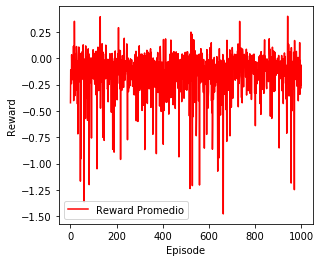

In [18]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(rewards_promedio, color = 'r', label = "Reward Promedio")
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [36]:
info

{'sample_time': 3.0,
 'patient_name': 'adolescent#002',
 'meal': 0.0,
 'patient_state': array([ 2.90259775e+01,  2.10430753e+02,  7.64266667e+01, -1.16117396e-10,
        -2.53207702e-13,  6.10864419e+03,  1.19635507e+05,  1.17386289e+05,
         1.10861152e+05,  5.03918051e+03,  7.93938419e+04,  4.78484584e+04,
        -6.80626727e-13])}

# Probando el Agente

100% (200 of 200) |######################| Elapsed Time: 0:00:27 Time:  0:00:27


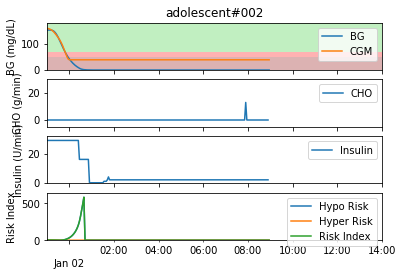

In [47]:
env = gym.make(envName)
observation = env.reset()

#queue_glucosa = deque(maxlen = num_estados_glucosa)
#queue_insulina = deque(maxlen = num_estados_insulina)
#state_queue = deque(maxlen = num_estados)
state_queue = deque([[observation[0], 0.0, 0.0]]*num_estados, maxlen = num_estados)

#queue_glucosa = deque([observation[0] for i in range(num_estados_glucosa)], maxlen = num_estados_glucosa)
#queue_insulina = deque([0.0 for i in range(num_estados_glucosa)], maxlen = num_estados_insulina)
    
num_steps_test = 200

s = 0
while False:#s < max_estados:
    env.render(mode='human')

    observation, reward, done, info = env.step(0.0)
    
    #queue_glucosa.append(observation[0])
    #queue_insulina.append(0.0)
    state_queue.append([observation[0], 0.0, info['meal']])
    s+=1
    #state.append(observation[0])
    #next_state.append(observation[0])
    
for s in progressbar.progressbar(range(num_steps_test)):
    env.render(mode='human')
    
    #state = np.concatenate((np.array(queue_glucosa)/max_glucosa, np.array(queue_insulina)/max_accion))
    state = np.array(state_queue)*max_norm
    state = np.reshape(state, (1,-1))
    #x = np.reshape(np.asarray(state), (1,-1))
    #x = x/500.0
    #print(state)
    #print(red.predict(state))
    #Se escoge la accion de acuerdo con la politica optima.
    action = np.argmax(red.predict(state))
    #print(state)
    #print(red.predict(x))
    
    observation, reward, done, info = env.step(action)#env.step(convertirAccion(action, max_accion, num_acciones))
    #print(observation)
    #state.append(observation[0])
    #queue_glucosa.append(observation[0])
    #queue_insulina.append(action)
    state_queue.append([observation[0], action, info['meal']])
    if False:#done:
        print("Episode finished after {} timesteps".format(s + 1))
        break

In [37]:
info

{'sample_time': 3.0,
 'patient_name': 'adolescent#002',
 'meal': 0.0,
 'patient_state': array([ 2.90259775e+01,  2.10430753e+02,  7.64266667e+01, -1.16117396e-10,
        -2.53207702e-13,  6.10864419e+03,  1.19635507e+05,  1.17386289e+05,
         1.10861152e+05,  5.03918051e+03,  7.93938419e+04,  4.78484584e+04,
        -6.80626727e-13])}

In [10]:
print(state)
print(np.argmax(red.predict(state)))
print(red.predict(state))

[[0.195 0.5   0.    0.195 0.5   0.    0.195 0.5   0.    0.195 0.5   0.
  0.195 0.5   0.    0.195 0.5   0.    0.195 0.5   0.    0.195 0.5   0.
  0.195 0.5   0.    0.195 0.5   0.    0.195 0.5   0.    0.195 0.5   0.
  0.195 0.5   0.    0.195 0.5   0.    0.195 0.5   0.    0.195 0.5   0.
  0.195 0.5   0.    0.195 0.5   0.    0.195 0.5   0.    0.195 0.5   0.   ]]
15
[[-0.00541855 -0.03454683 -0.21173063 -0.02247252 -0.08056487 -0.01917425
  -0.03605382 -0.11660269 -0.01635593  0.06704849  0.10057518 -0.07552926
  -0.09284229  0.09571654 -0.02005951  0.16924767  0.12845863  0.09882414
  -0.23182926 -0.10603409 -0.00614036 -0.15324043 -0.04304627 -0.0239891
  -0.02953745 -0.03065731  0.01991903  0.05359905  0.01258527  0.02308823]]


# Guardar las redes

In [ ]:
def guardarModelo(pModelo, pRutaModelo):
    pModelo.save(pRutaModelo)

In [ ]:
ruta_modelo = "./modelos/red_new_17.h5"
ruta_modelo_target = "./modelos/red_target_new_17.h5"

#Las red_new 5, 6 son las que mejor han funcionado
#La 8 es la segunda mejor hasta ahora.
#La 9 es la mejor hasta ahora.
#La 10 no sirve para nada
#La 11 no esta mal pero toca entrenar con mas steps (por ahi 200).
#La 12 aun no funciona bien. Entrenar mas.
#De la 14 en adelante ahora se entrena creando aleatoriamente el environment cada vez que lo reinicia.
#La 15 no está mal pero inyecta insulina cuando el azucar esta por debajo de maso 60 (yo creo que es
#por lo que el episodio termina ahi, entonces no logra aprender que no tiene que inyectar ahi. Puedo
#probar cambiando la reward function)
#La 16 es similar a la 15.
#La 17 es sin armar el estado al comienzo, sino que inicializandolo en valores constantes.

guardarModelo(red, ruta_modelo)
guardarModelo(red_target, ruta_modelo_target)

In [5]:
ruta_modelo = "./modelos/red_new_15.h5"
ruta_modelo_target = "./modelos/red_target_new_15.h5"

red = load_model(ruta_modelo)
red_target = load_model(ruta_modelo_target)

100% (200 of 200) |######################| Elapsed Time: 0:00:31 Time:  0:00:31


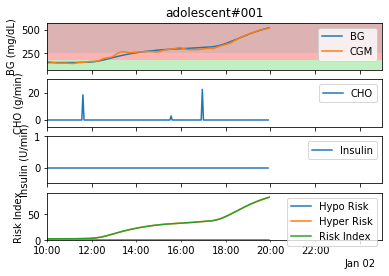

In [42]:
from gym.envs.registration import register
register(
    id='simglucose-adolescent2-v2',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'adolescent#002'}
)

envName = 'simglucose-adolescent2-v2'
env = gym.make(envName) 

observation = env.reset()
for t in progressbar.progressbar(range(200)):
    env.render(mode='human')
    #print(observation)
    # Action in the gym environment is a scalar
    # representing the basal insulin, which differs from
    # the regular controller action outside the gym
    # environment (a tuple (basal, bolus)).
    # In the perfect situation, the agent should be able
    # to control the glucose only through basal instead
    # of asking patient to take bolus
    observation, reward, done, info = env.step(0)
    #if done:
    #    print("Episode finished after {} timesteps".format(t + 1))
    #    break

In [11]:
from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from datetime import timedelta
from datetime import datetime

# specify start_time as the beginning of today
now = datetime.now()
start_time = datetime.combine(now.date(), datetime.min.time())

# --------- Create Random Scenario --------------
# Specify results saving path
path = './results'

# Create a simulation environment
patient = T1DPatient.withName('adolescent#001')
sensor = CGMSensor.withName('Dexcom', seed=1)
pump = InsulinPump.withName('Insulet')
scenario = RandomScenario(start_time=start_time, seed=1)
env = T1DSimEnv(patient, sensor, pump, scenario)

# Create a controller
controller = BBController()

# Put them together to create a simulation object
s1 = SimObj(env, controller, timedelta(days=1), animate=False, path=path)
results1 = sim(s1)
print(results1)

# --------- Create Custom Scenario --------------
# Create a simulation environment
patient = T1DPatient.withName('adolescent#001')
sensor = CGMSensor.withName('Dexcom', seed=1)
pump = InsulinPump.withName('Insulet')
# custom scenario is a list of tuples (time, meal_size)
scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)]
scenario = CustomScenario(start_time=start_time, scenario=scen)
env = T1DSimEnv(patient, sensor, pump, scenario)

# Create a controller
controller = BBController()

# Put them together to create a simulation object
s2 = SimObj(env, controller, timedelta(days=1), animate=False, path=path)
results2 = sim(s2)
print(results2)


# --------- batch simulation --------------
# Re-initialize simulation objects
s1.reset()
s2.reset()

# create a list of SimObj, and call batch_sim
s = [s1, s2]
results = batch_sim(s, parallel=True)
print(results)

Process ID: 3218
Simulation starts ...
Simulation Completed!
                             BG         CGM  CHO   insulin  LBGI      HBGI  \
Time                                                                         
2020-02-07 00:00:00  149.020000  165.793949  0.0  0.013933   0.0  2.755276   
2020-02-07 00:03:00  149.020000  161.582022  0.0  0.013933   0.0  2.755276   
2020-02-07 00:06:00  149.020000  159.239373  0.0  0.013933   0.0  2.755276   
2020-02-07 00:09:00  149.020000  157.472710  0.0  0.013933   0.0  2.755276   
2020-02-07 00:12:00  149.020000  156.108950  0.0  0.013933   0.0  2.755276   
...                         ...         ...  ...       ...   ...       ...   
2020-02-07 23:48:00  140.377422  140.872461  0.0  0.013933   0.0  1.706344   
2020-02-07 23:51:00  139.944000  139.740305  0.0  0.013933   0.0  1.658886   
2020-02-07 23:54:00  139.528133  138.839245  0.0  0.013933   0.0  1.613846   
2020-02-07 23:57:00  139.128508  138.273393  0.0  0.013933   0.0  1.571027   
202